# Ligand Selection Via Clustering

In [97]:
import sys_path
from Data import Data
from chem_utils import ChemDraw
from feature_utils import mordred
from plot_utils import embedding_plot

import pandas as pd
import numpy as np

from rdkit import Chem


In [98]:
# Ligand Data

ligands = pd.read_csv('data\ligand_selection\ligands.csv')
selected = pd.read_csv('data\direct_arylation\ligand-boltzmann_dft.csv')

# Make sure they are in canonical SMILES

ligands['ligand_SMILES'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in ligands['ligand_SMILES'].values]
selected['ligand_SMILES'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in selected['ligand_SMILES'].values]

# Compute mordred descriptors

ligand_descriptors = Data(mordred(ligands['ligand_SMILES'].values, dropna=True))
ligand_descriptors.data.head()

C:\Users\User\Anaconda3\envs\bro\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CCCCP(C12CC3CC(CC(C3)C1)C2)C12CC3CC(CC(C3)C1)C2,21.089984,15.696653,0,0,33.062611,2.637263,5.274527,33.062611,1.322504,...,10.826575,61.647833,358.278938,5.598108,1252,46,156.0,196.0,5.652778,5.083333
1,CP(c1ccccc1)c1ccccc1,10.635111,9.197041,0,0,18.814625,2.307250,4.614501,18.814625,1.343902,...,9.282754,45.217583,200.075487,7.410203,307,18,68.0,77.0,3.833333,3.222222
2,O=C(O)c1ccccc1P(c1ccccc1)c1ccccc1,16.987142,14.260922,1,0,29.011287,2.437269,4.874538,29.011287,1.318695,...,9.949846,55.991470,306.080966,8.272459,960,34,112.0,131.0,6.166667,4.972222
3,CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1,21.787059,17.617672,0,0,37.663644,2.449490,4.898979,37.663644,1.345130,...,10.183503,63.214164,390.247638,6.194407,1845,44,144.0,169.0,6.777778,6.333333
4,COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1,18.970563,14.924370,0,0,33.147333,2.419870,4.839741,33.147333,1.325893,...,10.026369,59.512963,352.122831,7.654844,1518,39,126.0,147.0,7.527778,5.833333


In [99]:
# Save SMILES for later
ligand_descriptors.data = ligand_descriptors.base_data
smiles = ligand_descriptors.data['SMILES']

# Remove non-numerical and zero variance columns
ligand_descriptors.clean()

# Standardize
ligand_descriptors.standardize(scaler='minmax', target=None)

# Remove highly correlated features
ligand_descriptors.uncorrelated(threshold=0.99, target=None)

# Final descriptors
ligand_descriptors.data.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpMAD_A,LogEE_A,VE1_A,...,PetitjeanIndex,MWC03,MWC06,SRW05,SRW09,TSRW10,WPath,WPol,mZagreb1,mZagreb2
0,0.444590,0.355134,0.0,0.0,0.448637,0.852301,0.912925,0.787812,0.684403,0.601208,...,1.0,0.782500,0.861620,0.0,0.0,0.484692,0.127556,0.421053,0.159118,0.333333
1,0.168693,0.142133,0.0,0.0,0.193589,0.410929,0.440158,0.858073,0.373793,0.296232,...,1.0,0.432822,0.463688,0.0,0.0,0.216616,0.027439,0.126316,0.081049,0.132132
2,0.336319,0.308084,1.0,0.0,0.376116,0.584821,0.626418,0.775303,0.586675,0.480527,...,1.0,0.631541,0.663497,0.0,0.0,0.392402,0.096620,0.294737,0.181168,0.321321
3,0.462986,0.418089,0.0,0.0,0.530999,0.601165,0.643926,0.862107,0.700425,0.607052,...,1.0,0.726947,0.737658,0.0,0.0,0.510248,0.190380,0.400000,0.207390,0.468468
4,0.388660,0.329826,0.0,0.0,0.450154,0.561551,0.601494,0.798940,0.642225,0.537409,...,1.0,0.674696,0.686525,0.0,0.0,0.449859,0.155737,0.347368,0.239571,0.414414


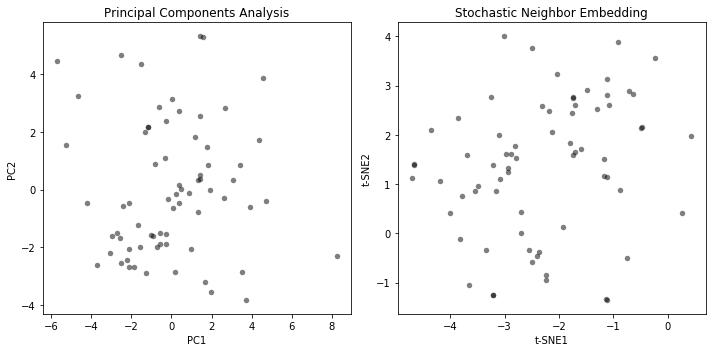

In [5]:
# Visualize the ligand space
embedding_plot(ligand_descriptors.data.values, export_path='direct_arylation_ligand_selection/ligand_embedding_not_clustered')

In [100]:
# We can use the k_means initialization function from the
# BO framework to run clustering.

from init_scheme import k_means

# k_means uses an objective object so we need to make one

from objective import objective

obj = objective(domain=ligand_descriptors.data)

cluster_labels = k_means(obj, 2, visualize=False, seed=0, 
                   n_init=30, return_clusters=True)

9 clusters selected by silhouette score...


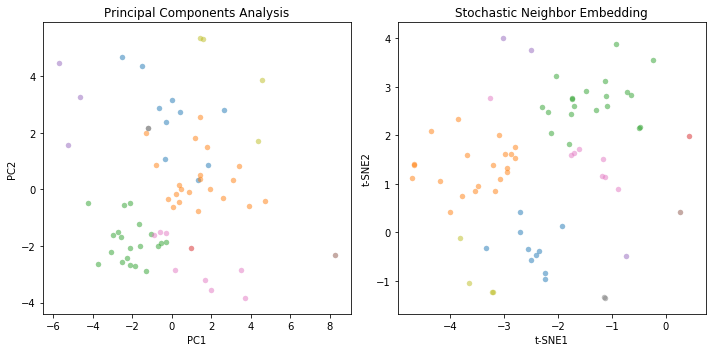

In [32]:
# Visualize the clusters

embedding_plot(ligand_descriptors.data.values, labels=cluster_labels, export_path='direct_arylation_ligand_selection/ligand_embedding_clustered')

In [101]:
selected_ligands = [smiles[smiles == smi].index.values[0] for smi in selected['ligand_SMILES'].values]

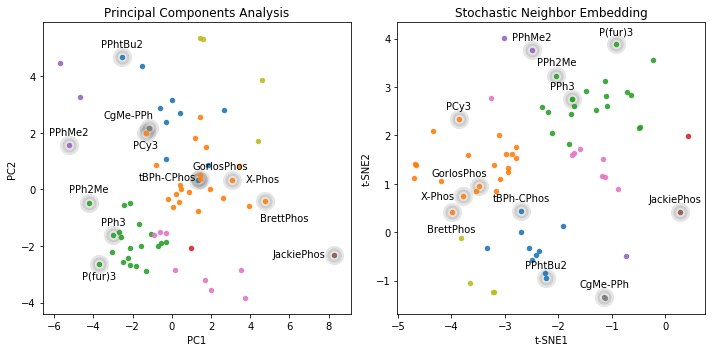

In [108]:
# Now lets make a custom figure showing the selected ligands
data = ligand_descriptors.data.values
labels = cluster_labels

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
    
# PCA
pca = PCA(n_components=2, copy=True)
pca.fit(data)
pca_results = pca.transform(data)

# t-SNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=10)
tsne_results = tsne.fit_transform(data)
    
# Unique labels
clusters = list(set(labels))
labels = np.array(labels)

# Selected data
tsne_selected = tsne_results[selected_ligands]
pca_selected = pca_results[selected_ligands]

# Plot with matplotlib    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(pca_selected[:,0], 
            pca_selected[:,1], 
            color='black',
            alpha=0.1,
            lw=5,
            s=200)
"""
ax2.scatter(tsne_results[np.argwhere(cluster_labels == 1).flatten()][:,0][[0]], 
            tsne_results[np.argwhere(cluster_labels == 1).flatten()][:,1][[0]], 
            color='yellow',
            alpha=0.1,
            lw=5,
            s=200)
"""
ax2.scatter(tsne_selected[:,0], 
            tsne_selected[:,1], 
            color='black',
            alpha=0.1,
            lw=5,
            s=200)

names = selected['ligand_file_name'].values

textxs = [20, -20, 20, -35, 0, 0, 0 ,0 ,0 ,0, -30, 30]
textys = [-20, 10, 10, -3, -15, -15, 10, 10 ,10 ,10, 0, -3]

for x, y, name, xoff, yoff in zip(pca_selected[:,0], pca_selected[:,1], names, textxs, textys):

    ax1.annotate(name, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(xoff,yoff), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

textxs = [0, 0, -20, -5, 0, 0, 0 ,-10 ,0 ,0, 0, -25]
textys = [-20, 10, 10, 10, 10, 10, 10 ,10 ,10 ,10, 10, -3]

for x, y, name, xoff, yoff in zip(tsne_selected[:,0], tsne_selected[:,1], names, textxs, textys):

    ax2.annotate(name, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(xoff,yoff), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for cluster_i in clusters:
    index_i = np.argwhere(labels == cluster_i).flatten()
    ax1.scatter(pca_results[:,0][index_i],
                pca_results[:,1][index_i],
                s=30,
                lw=0,
                alpha=0.9)
    ax2.scatter(tsne_results[:,0][index_i],
                tsne_results[:,1][index_i],
                s=30,
                lw=0,
                alpha=0.9)
    
ax1.set(xlabel='PC1', ylabel='PC2')
ax1.set_title('Principal Components Analysis', fontsize=12)
ax2.set(xlabel='t-SNE1', ylabel='t-SNE2')
ax2.set_title('Stochastic Neighbor Embedding', fontsize=12)
fig.tight_layout()

plt.savefig('direct_arylation_ligand_selection/initial_ligand_selection.svg', format='svg', dpi=1200, bbox_inches='tight')

In [109]:
selected_clusters = []
for cluster_i in clusters:
    
    index_i = np.argwhere(labels == cluster_i).flatten()
    
    for sel in index_i:
        any_sel = False
        if sel in selected_ligands:
            any_sel = True
            break
            
    selected_clusters.append([cluster_i, any_sel])
            
selection_scheme = pd.DataFrame(selected_clusters, columns=['cluster_label', 'selected'])

In [110]:
missing = selection_scheme[selection_scheme['selected'] == False]
missing

,cluster_label,selected
3,3,False
6,6,False
8,8,False


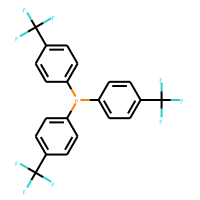

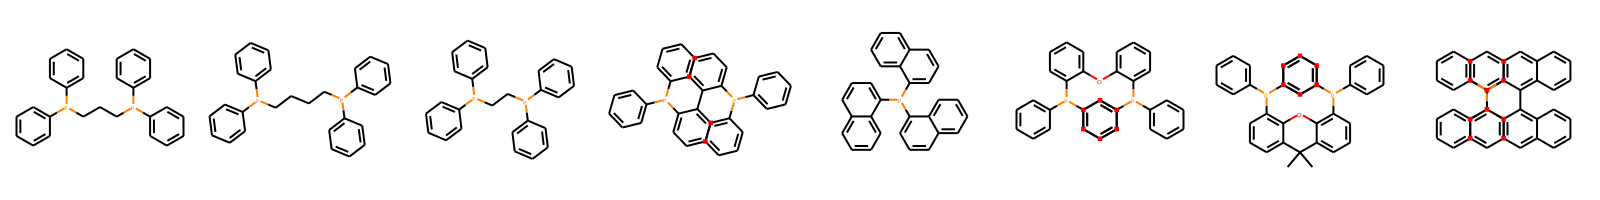

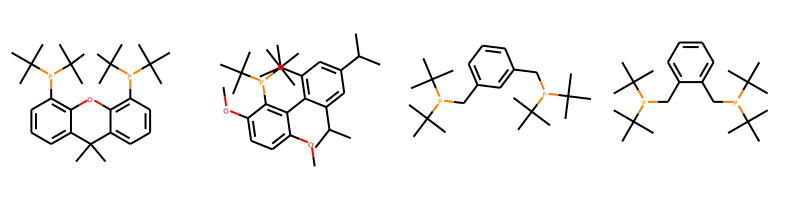

In [111]:
# Missing clusters include a single ligand cluster and (primarily) bidentate ligand clusters

for missing_i in missing['cluster_label'].values:
    cdx = ChemDraw(smiles[(np.argwhere(cluster_labels == missing_i)).flatten()])
    cdx.show()

# Extended Ligand Set

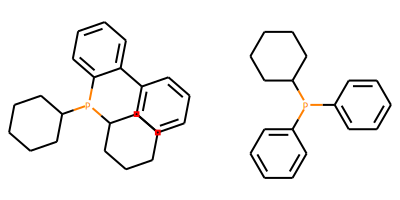

In [142]:
Cy_JohnPhos = 'c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1'
PPh2Cy = 'c1ccc(P(c2ccccc2)C2CCCCC2)cc1'

cdx = ChemDraw([Cy_JohnPhos, PPh2Cy])
cdx.show()

l1 = ligands[ligands['ligand_SMILES'] == Cy_JohnPhos].index.values[0]
l2 = ligands[ligands['ligand_SMILES'] == PPh2Cy].index.values[0]

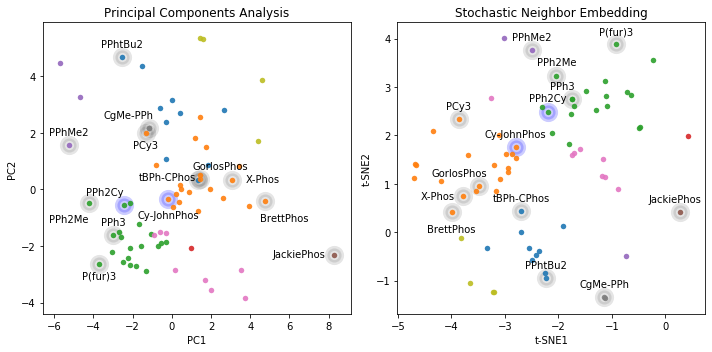

In [149]:
# Now lets make a custom figure showing the selected ligands
data = ligand_descriptors.data.values
labels = cluster_labels

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
    
# PCA
pca = PCA(n_components=2, copy=True)
pca.fit(data)
pca_results = pca.transform(data)

# t-SNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=10)
tsne_results = tsne.fit_transform(data)
    
# Unique labels
clusters = list(set(labels))
labels = np.array(labels)

# Selected data
tsne_selected = tsne_results[selected_ligands]
pca_selected = pca_results[selected_ligands]

tsne_all = tsne_results[list(selected_ligands) + [l1, l2]]
pca_all = pca_results[list(selected_ligands) + [l1, l2]]

# Plot with matplotlib    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(pca_selected[:,0], 
            pca_selected[:,1], 
            color='black',
            alpha=0.1,
            lw=5,
            s=200)

ax1.scatter(pca_results[[l1,l2]][:,0], 
            pca_results[[l1,l2]][:,1], 
            color='blue',
            alpha=0.2,
            lw=5,
            s=200)

ax2.scatter(tsne_selected[:,0], 
            tsne_selected[:,1], 
            color='black',
            alpha=0.1,
            lw=5,
            s=200)

ax2.scatter(tsne_results[[l1,l2]][:,0], 
            tsne_results[[l1,l2]][:,1], 
            color='blue',
            alpha=0.2,
            lw=5,
            s=200)

names = list(selected['ligand_file_name'].values) + ['Cy-JohnPhos', 'PPh2Cy']

textxs = [20, -20, 20, -35, 0, 0, -20 ,0 ,0 ,0, -30, 30, 0, -20]
textys = [-20, 10, 10, -3, -15, -15, -20, 10 ,10 ,10, 0, -3, -20, 10]

for x, y, name, xoff, yoff in zip(pca_all[:,0], pca_all[:,1], names, textxs, textys):

    ax1.annotate(name, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(xoff,yoff), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

textxs = [0, 0, -20, -5, 0, 0, 0 ,-10 ,0 ,0, 0, -25, 0, 0]
textys = [-20, 10, 10, 10, 10, 10, 10 ,10 ,10 ,10, 10, -3, 10, 10]

for x, y, name, xoff, yoff in zip(tsne_all[:,0], tsne_all[:,1], names, textxs, textys):

    ax2.annotate(name, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(xoff,yoff), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for cluster_i in clusters:
    index_i = np.argwhere(labels == cluster_i).flatten()
    ax1.scatter(pca_results[:,0][index_i],
                pca_results[:,1][index_i],
                s=30,
                lw=0,
                alpha=0.9)
    ax2.scatter(tsne_results[:,0][index_i],
                tsne_results[:,1][index_i],
                s=30,
                lw=0,
                alpha=0.9)
    
ax1.set(xlabel='PC1', ylabel='PC2')
ax1.set_title('Principal Components Analysis', fontsize=12)
ax2.set(xlabel='t-SNE1', ylabel='t-SNE2')
ax2.set_title('Stochastic Neighbor Embedding', fontsize=12)
fig.tight_layout()

plt.savefig('direct_arylation_ligand_selection/out_of_sample_ligand_selection.svg', format='svg', dpi=1200, bbox_inches='tight')

In [154]:
selected['ligand_SMILES'][1]

'C[C@]12C[C@@]3(C)O[C@](C)(C[C@@](C)(O1)O3)P2c1ccccc1'

# Network graphic of search space

In [2]:
base_SMILES = ['O=C([O-])C.[Cs+]',
               'O=C([O-])C(C)(C)C.[Cs+]',
               'O=C([O-])C.[K+]',
               'O=C([O-])C(C)(C)C.[K+]', 
               'C(=O)([O-])[O-].[K+].[K+]',
               #'C(=O)([O-])[O-].[Na+].[Na+]',
               'C(=O)([O-])[O-].[Cs+].[Cs+]',
               'CCN(C(C)C)C(C)C']
solvent_SMILES = ['CCCC#N',
                  'CCCCOC(C)=O',
                  'CC(N(C)C)=O',
                  'CC1=CC=C(C)C=C1',
                  'CS(=O)C',
                  'CC(OCC)=O',
                  #'CC#N',
                  'O=CN(C)C',
                  'CC1=CC=CC=C1',
                  #'C1CCOC1',
                  'O1CCOCC1']
precatalyst_SMILES = ['[CH2-]C=C.[CH2-]C=C.Cl[Pd+].Cl[Pd+]',
                      'CC(=O)[O-].CC(=O)[O-].[Pd+2]',
                      'CC(C)(C)C(=O)[O-].CC(C)(C)C(=O)[O-].[Pd+2]',
                      'C1=CC=C(C=C1)C=CC(=O)C=CC2=CC=CC=C2.C1=CC=C(C=C1)C=CC(=O)C=CC2=CC=CC=C2.C1=CC=C(C=C1)C=CC(=O)C=CC2=CC=CC=C2.[Pd].[Pd]',
                      'C=C[CH-]C1=CC=CC=C1.C=C[CH-]C1=CC=CC=C1.Cl[Pd+].Cl[Pd+]']

In [3]:
# Features for search space
ligands = pd.read_csv('data\ligand_selection\ligands.csv')

ligand_descriptors = Data(mordred(ligands['ligand_SMILES'].values, dropna=True, name='ligand_'))
base_descriptors = Data(mordred(base_SMILES, dropna=True, name='base_'))
solvent_descriptors = Data(mordred(solvent_SMILES, dropna=True, name='solvent_'))
precatalyst_descriptors = Data(mordred(precatalyst_SMILES, dropna=True, name='precat'))
concentrations = np.linspace(0.057, 0.153, 10)
temperatures = np.linspace(90, 120, 10)

C:\Users\User\Anaconda3\envs\bro\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [12]:
# Clean each data set individually

for descriptors in [ligand_descriptors, base_descriptors, solvent_descriptors, precatalyst_descriptors]:
    
    descriptors.data = descriptors.base_data.copy()
    
    # Remove non-numerical and zero variance columns
    descriptors.clean()
    
    # Remove highly correlated features
    descriptors.uncorrelated(threshold=0.9, target=None)

    # Final descriptors
    print(len(descriptors.data.columns))

363
23
154
32


In [13]:
# Combined descriptors

# Column labels
columns = []
for descriptors in [ligand_descriptors, base_descriptors, solvent_descriptors]:
    columns = columns + list(descriptors.data.columns.values)
columns = columns + ['concentration', 'temperature']

# Build space
space = []
for l in ligand_descriptors.data.values:
    for b in base_descriptors.data.values:
        for s in solvent_descriptors.data.values:
            for c in concentrations:
                for t in temperatures:
                    entry = list(l) + list(b) + list(s) + [c] + [t]
                    space.append(entry)
                    
space = Data(pd.DataFrame(space, columns=columns))
space.standardize(scaler='minmax', target=None)

space.data.head()

,ligand_ABC,ligand_nAcid,ligand_nBase,ligand_SpMax_A,ligand_SpMAD_A,ligand_VE2_A,ligand_VR2_A,ligand_nAromAtom,ligand_nAtom,ligand_nBridgehead,...,solvent_EState_VSA7,solvent_VSA_EState1,solvent_VSA_EState8,solvent_nRot,solvent_GGI3,solvent_JGI1,solvent_JGI3,solvent_Radius,concentration,temperature
0,0.44459,0.0,0.0,0.852301,0.787812,0.30034,0.427624,0.0,0.619718,1.0,...,0.713934,0.0,0.474397,0.333333,0.5,0.25,0.75,0.5,0.0,0.000000
1,0.44459,0.0,0.0,0.852301,0.787812,0.30034,0.427624,0.0,0.619718,1.0,...,0.713934,0.0,0.474397,0.333333,0.5,0.25,0.75,0.5,0.0,0.111111
2,0.44459,0.0,0.0,0.852301,0.787812,0.30034,0.427624,0.0,0.619718,1.0,...,0.713934,0.0,0.474397,0.333333,0.5,0.25,0.75,0.5,0.0,0.222222
3,0.44459,0.0,0.0,0.852301,0.787812,0.30034,0.427624,0.0,0.619718,1.0,...,0.713934,0.0,0.474397,0.333333,0.5,0.25,0.75,0.5,0.0,0.333333
4,0.44459,0.0,0.0,0.852301,0.787812,0.30034,0.427624,0.0,0.619718,1.0,...,0.713934,0.0,0.474397,0.333333,0.5,0.25,0.75,0.5,0.0,0.444444


In [14]:
space.data.shape

(441000, 542)

In [54]:
# We can use the k_means initialization function from the
# BO framework to run clustering.

from init_scheme import k_means

# k_means uses an objective object so we need to make one

from objective import objective

space_fraction = 0.05
obj = objective(domain=space.data.sample(int(space.data.shape[0] * space_fraction), random_state=0).reset_index(drop=True))

cluster_labels = k_means(obj, 10, visualize=False, seed=0, n_init=1, return_clusters=True)

11 clusters selected by silhouette score...


In [55]:
centers = k_means(obj, 10, visualize=False, seed=0, n_init=1, return_centroids=True)

11 clusters selected by silhouette score...


In [56]:
# t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=10)
tsne_results = tsne.fit_transform(obj.domain)

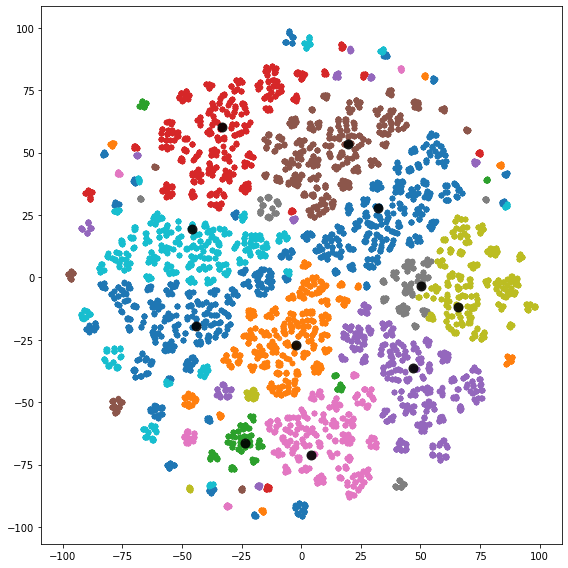

In [57]:
# Visualize the clusters
clusters = list(set(cluster_labels))
clusters.sort()

from matplotlib import pyplot as plt
  
fig, (ax2) = plt.subplots(1, figsize=(8,8))

for cluster_i in clusters:
    index_i = np.argwhere(cluster_labels == cluster_i).flatten()
    ax2.scatter(tsne_results[:,0][index_i],
                tsne_results[:,1][index_i],
                s=30,
                lw=0,
                alpha=0.9)
    
ax2.scatter(tsne_results[:,0][centers.index.values],
            tsne_results[:,1][centers.index.values],
            color='black',
            s=100,
            lw=0,
            alpha=0.9)
    
#ax2.set(xlabel='t-SNE1', ylabel='t-SNE2')
#ax2.set_title('Stochastic Neighbor Embedding', fontsize=12)
fig.tight_layout()

#plt.savefig('direct_arylation_space/space_embedding_0.05_of_data.svg', format='svg', dpi=1200, bbox_inches='tight')

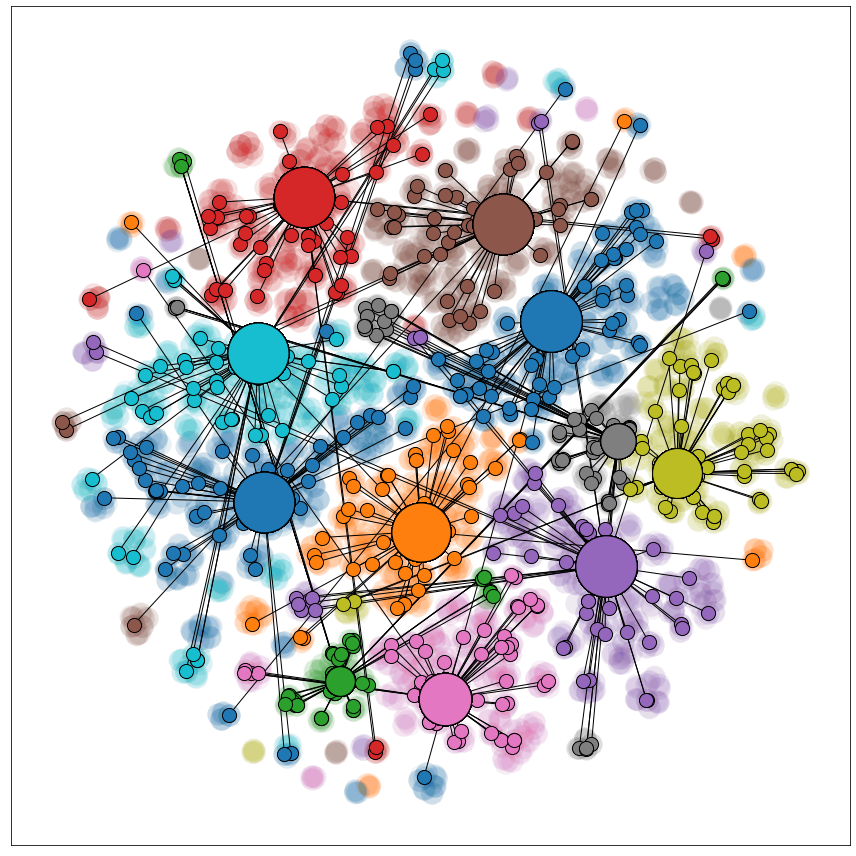

In [85]:
# Visualize the clusters
import random
keep = 50

colors = ['C' + str(i) for i in range(len(clusters))]

fig, (ax2) = plt.subplots(1, figsize=(12,12))

# Individual Cluster points
for cluster_i, color, seed in zip(clusters, colors, range(len(clusters))):
    index_i = np.argwhere(cluster_labels == cluster_i).flatten()
    N = len(index_i)
    ax2.scatter(tsne_results[:,0][index_i],
                tsne_results[:,1][index_i],
                s=500,
                lw=0,
                alpha=0.02,
                zorder=1,
                color=color)
    
    # Connect all the centroids together
    center = centers.index.values[cluster_i]
    
    # Connect individual points to the centroids
    random.seed(seed)
    index_i = random.sample(list(np.argwhere(cluster_labels == cluster_i).flatten()), keep)
    for point in index_i:
        x = tsne_results[:,0][[center, point]]    
        y = tsne_results[:,1][[center, point]]  
    
        ax2.plot(x, y, lw=1, color='black', zorder=3)
        ax2.scatter(x, y, s=200, lw=1, edgecolors='black', color=color, zorder=4, alpha=1)
        
        ax2.scatter([x[0]], [y[0]], s=N*1.5, lw=1, edgecolors='black', color=color, zorder=5)
        
ax2.set_xticks([])
ax2.set_yticks([])
fig.tight_layout()

plt.savefig('direct_arylation_space/space_embedding_0.05_of_data.svg', format='svg', dpi=1200, bbox_inches='tight')

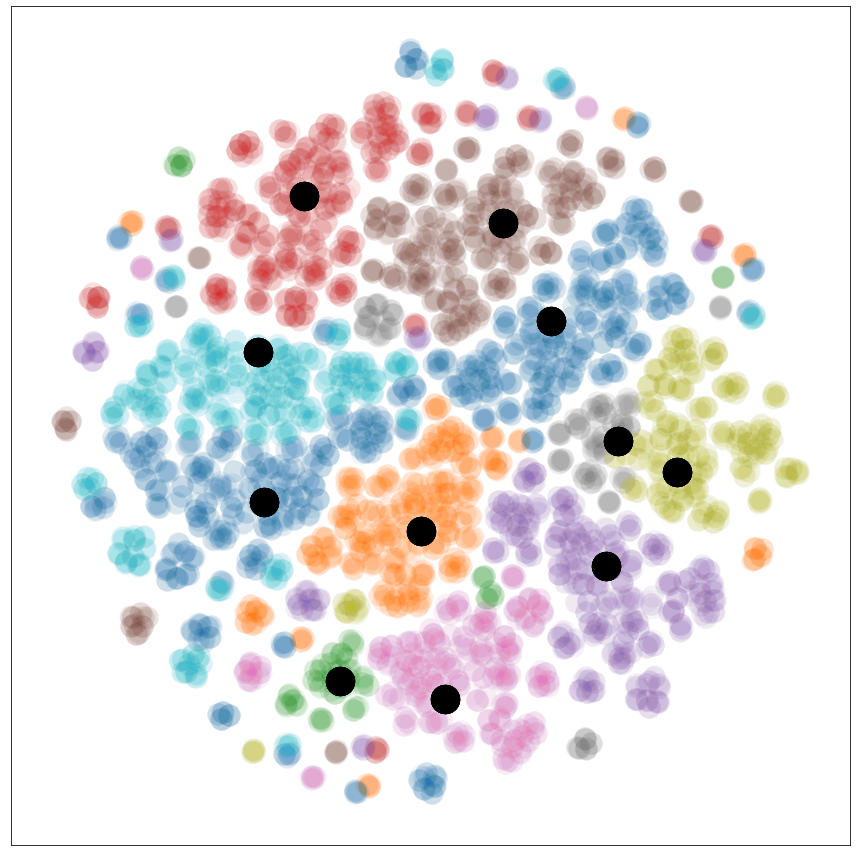

In [96]:
# Visualize the clusters
import random
keep = 5

colors = ['C' + str(i) for i in range(len(clusters))]

fig, (ax2) = plt.subplots(1, figsize=(12,12))

# Individual Cluster points
for cluster_i, color, seed in zip(clusters, colors, range(len(clusters))):
    index_i = np.argwhere(cluster_labels == cluster_i).flatten()
    N = len(index_i)

    ax2.scatter(tsne_results[:,0][index_i],
                tsne_results[:,1][index_i],
                s=500,
                lw=0,
                alpha=0.02,
                zorder=1,
                color=color)

    # Connect all the centroids together
    center = centers.index.values[cluster_i]
    
    # Connect individual points to the centroids
    random.seed(seed)
    index_i = random.sample(list(np.argwhere(cluster_labels == cluster_i).flatten()), keep)
    for point in index_i:
        x = tsne_results[:,0][[center, point]]    
        y = tsne_results[:,1][[center, point]]  
    
        #ax2.plot(x, y, lw=2, color='black', zorder=3)
        #ax2.scatter(x, y, s=800, lw=1, edgecolors='black', color='black', zorder=4, alpha=1)
        
        ax2.scatter([x[0]], [y[0]], s=800, lw=1, edgecolors='black', color='black', zorder=5)
        
ax2.set_xticks([])
ax2.set_yticks([])
fig.tight_layout()

plt.savefig('direct_arylation_space/space_embedding_0.05_of_data_subset.svg', format='svg', dpi=1200, bbox_inches='tight')

In [60]:
len(obj.domain)

22050